In [1]:
from torch import nn
from torchvision import models 
from torchvision import transforms as T 
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter
import torch
import numpy as np 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, SubsetRandomSampler

In [2]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [5]:
data_transforms = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
dataset = ImageFolder(root='images', transform=data_transforms)
dataset.classes = [int(i) for i in dataset.classes]
for (_, (img, _)) in enumerate(dataset):
    img = img.unsqueeze(0)

In [6]:
dataset_size = len(dataset)
dataset_indices = list(range(dataset_size))
test_split_indices = int(np.floor(0.2 * dataset_size))
train_indices  = dataset_indices[test_split_indices:]
test_indices = dataset_indices[:test_split_indices]

In [7]:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
train_loader = DataLoader(dataset=dataset, shuffle = False, batch_size=16, sampler=train_sampler, num_workers=2)
test_loader = DataLoader(dataset=dataset, shuffle = False, batch_size=16, sampler=test_sampler, num_workers=2)

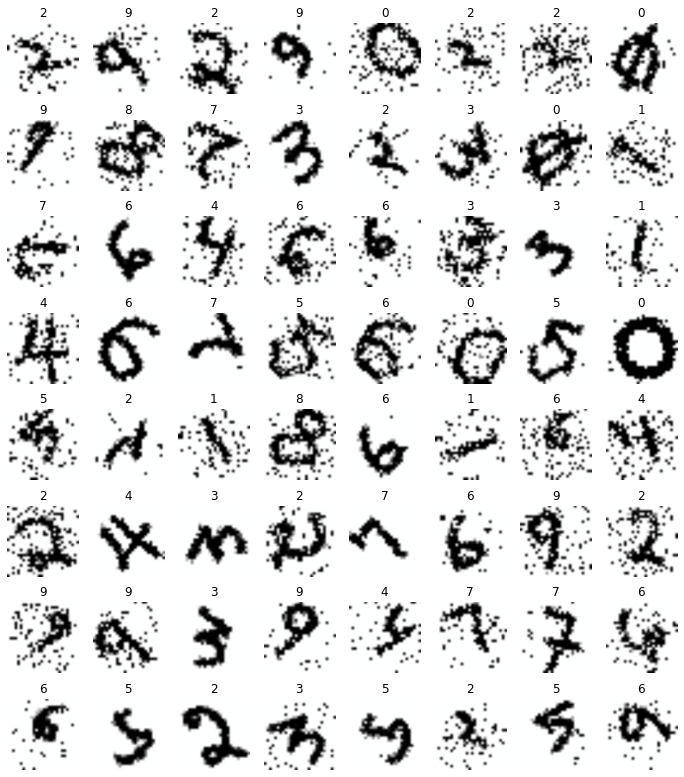

In [6]:
figure = plt.figure(figsize=(12, 12), linewidth=10)
cols, rows = 8, 8

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_loader.dataset), size=(1,)).item()
    img, label = train_loader.dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis('off')
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img, cmap='gray')

plt.subplots_adjust(top=1.)    
plt.show()

In [8]:
# create network
net = models.vgg16(pretrained=True)
for param in net.parameters():
    param.requires_grad = False
    
net.classifier[6] = nn.Sequential(nn.Linear(4096, 1000),
                                        nn.ReLU(inplace=True),
                                        nn.Dropout(0.5),
                                        nn.Linear(1000, 10),
                                        nn.Softmax())
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
writer = SummaryWriter()

In [9]:
net.load_state_dict(torch.load('model(04-05-22).pth'))

<All keys matched successfully>

In [8]:
for epoch in range(5):
    
    avg_loss = 0.0
    total_correct = 0
    
    # set network to training mode
    net.train()
    print(f"epoch:  {epoch + 1}")
      
    for i, data in enumerate(train_loader):
        
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        # clear the gradients 
        optimizer.zero_grad()
        
        # forward pass
        outputs = net(images)
        
        # compute loss
        loss = criterion(outputs, labels)
        
        # backpropagation step
        loss.backward()
       
        # update parameters
        optimizer.step()
        _, predictions = torch.argmax(outputs, 1)

        avg_loss = loss.item() / len(train_loader.dataset)
        total_correct += torch.sum(predictions == labels)
        lr_scheduler.step()
    
    writer.add_scalar("Train Loss", avg_loss / len(train_loader.dataset), epoch)
    writer.add_scalar("Train Accuracy", 100 * (total_correct / len(train_loader.dataset)), epoch)

epoch:  1


C:\Users\aravb\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch:  2
epoch:  3
epoch:  4
epoch:  5


In [ ]:
torch.save(net.state_dict(), "model(04-05-22).pth")

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
    
        inputs = inputs.to(device)
        labels = labels.to(device)
        output = net(inputs) # Feed Network

        output = torch.argmax(output, 1)
        y_pred.extend(output.cpu().numpy()) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

C:\Users\aravb\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [45]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)

[[   0    0   16 1285   71  989 3009]
 [   0    0   93  931  199  149 3998]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0]]
